In [1]:
import os
import warnings
import sys

import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet


In [2]:
import mlflow
import mlflow.sklearn

In [3]:

# mlflow server --backend-store-uri mlruns/ --default-artifact-root mlruns/ --host 127.0.0.1 --port 5000
remote_server_uri = "http://127.0.0.1:5000" # set to your server URI
mlflow.set_tracking_uri(remote_server_uri)  # or set the MLFLOW_TRACKING_URI in the env

In [4]:
mlflow.tracking.get_tracking_uri()

'http://127.0.0.1:5000'

In [9]:
mlflow

<module 'mlflow' from '/home/prince_nagpal/my_env/lib/python3.9/site-packages/mlflow/__init__.py'>

In [10]:
import os
import tarfile
import urllib

In [11]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

In [12]:
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [13]:
fetch_housing_data()

In [14]:
housing=pd.read_csv("/home/prince_nagpal/ml/my_env/datasets/housing/housing.csv")
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [15]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [16]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [17]:
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [18]:
train_set, test_set = split_train_test(housing, 0.2)

In [19]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [20]:
housing_with_id = housing.reset_index()   # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [21]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [22]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [ ]:
# log the parameters
mlflow.log_param("test_size", 0.2)
mlflow.log_param("random_state", 42)

In [24]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [25]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [26]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [27]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [28]:
housing = strat_train_set.copy()

<AxesSubplot: xlabel='longitude', ylabel='latitude'>

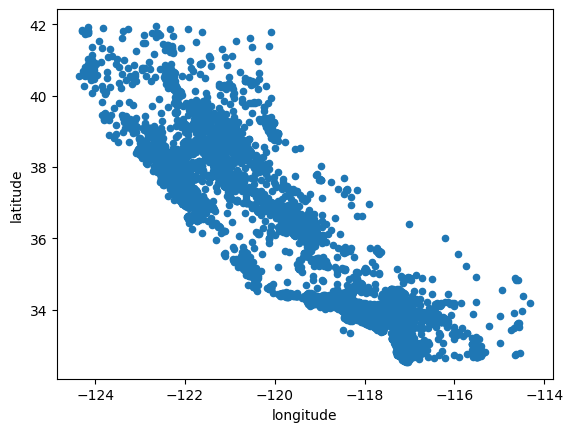

In [29]:
housing.plot(kind="scatter", x="longitude", y="latitude")

In [30]:
corr_matrix = housing.corr()

/tmp/ipykernel_111/2466220658.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing.corr()


In [31]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

In [32]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [33]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

/tmp/ipykernel_111/826279322.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing.corr()


median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

In [34]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [35]:
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median, inplace=True)

In [36]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

In [37]:
housing_num = housing.drop("ocean_proximity", axis=1)

In [38]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [39]:
imputer.statistics_
housing_num.median().values

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [40]:
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)


In [41]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


In [42]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [43]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [44]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [45]:
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [46]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [47]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]

        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [48]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [49]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [72]:
mlflow.end_run()

In [73]:
# start a new run
with mlflow.start_run(run_name='My first run') as run:
    # log the parameters
    mlflow.log_param("test_size", 0.2)
    mlflow.log_param("random_state", 42)

    # train a Linear regression
    from sklearn.linear_model import LinearRegression

    lin_reg = LinearRegression()
    lin_reg.fit(housing_prepared, housing_labels)
    
    some_data = housing.iloc[:5]
    some_labels = housing_labels.iloc[:5]
    some_data_prepared = full_pipeline.transform(some_data)
    print("Predictions:", lin_reg.predict(some_data_prepared))
    print("Labels:", list(some_labels))
    
    from sklearn.metrics import mean_squared_error
    housing_predictions = lin_reg.predict(housing_prepared)
    lin_mse = mean_squared_error(housing_labels, housing_predictions)
    lin_rmse = np.sqrt(lin_mse)
    lin_rmse

    # log the model
    mlflow.sklearn.log_model(lin_reg, "linear_regression_model")

    # log the evaluation metric
    mlflow.log_metric("mean_squared_error", lin_rmse)

Predictions: [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089]
Labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [76]:
# start a new run
with mlflow.start_run(run_name='My Second run') as run:
    # log the parameters
    mlflow.log_param("test_size", 0.2)
    mlflow.log_param("random_state", 42)

    # train a Decision Tree Regression
    from sklearn.tree import DecisionTreeRegressor

    tree_reg = DecisionTreeRegressor()
    tree_reg.fit(housing_prepared, housing_labels)
    
    housing_predictions = tree_reg.predict(housing_prepared)
    tree_mse = mean_squared_error(housing_labels, housing_predictions)
    tree_rmse = np.sqrt(tree_mse)
    tree_rmse
    
    from sklearn.model_selection import cross_val_score
    scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
    tree_rmse_scores = np.sqrt(-scores)
    
    def display_scores(scores):
        print("Scores:", scores)
        print("Mean:", scores.mean())
        print("Standard deviation:", scores.std())
    
    lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                              scoring="neg_mean_squared_error", cv=10)

    lin_rmse_scores = np.sqrt(-lin_scores)
    display_scores(lin_rmse_scores)
    
    

    # log the model
    mlflow.sklearn.log_model(tree_reg, "Decision_Tree_regression_model")

    # log the evaluation metric
    mlflow.log_metric("Scores", scores.mean())

Scores: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean: 69104.07998247063
Standard deviation: 2880.328209818062


In [77]:
# start a new run
with mlflow.start_run(run_name='My Third run') as run:
    # log the parameters
    mlflow.log_param("test_size", 0.2)
    mlflow.log_param("random_state", 42)

    # train a Random Forest Regression
    from sklearn.ensemble import RandomForestRegressor
    forest_reg = RandomForestRegressor()
    forest_reg.fit(housing_prepared, housing_labels)

    housing_predictions = forest_reg.predict(housing_prepared)
    forest_mse = mean_squared_error(housing_labels, housing_predictions)
    forest_rmse = np.sqrt(forest_mse)
    forest_rmse

    forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                              scoring="neg_mean_squared_error", cv=10)

    forest_rmse_scores = np.sqrt(-forest_scores)
    display_scores(forest_rmse_scores)

    

    # log the model
    mlflow.sklearn.log_model(forest_reg, "Random_Forest_regression_model")

    # log the evaluation metric
    mlflow.log_metric("Scores", forest_rmse)

Scores: [51410.73258489 48908.46363808 46813.66666674 52287.98149913
 47213.23867264 51809.38077063 52534.10011495 49977.78437058
 48674.20024184 53924.71932135]
Mean: 50355.42678808261
Standard deviation: 2278.796538422861


In [59]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [60]:
 grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [61]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
     print(np.sqrt(-mean_score), params)

64624.18679092073 {'max_features': 2, 'n_estimators': 3}
55620.57956657248 {'max_features': 2, 'n_estimators': 10}
52878.76423133077 {'max_features': 2, 'n_estimators': 30}
59730.24861444027 {'max_features': 4, 'n_estimators': 3}
52622.71038325101 {'max_features': 4, 'n_estimators': 10}
50708.29899265909 {'max_features': 4, 'n_estimators': 30}
59596.49182971054 {'max_features': 6, 'n_estimators': 3}
52230.18804503721 {'max_features': 6, 'n_estimators': 10}
50164.39504090229 {'max_features': 6, 'n_estimators': 30}
58705.19665121235 {'max_features': 8, 'n_estimators': 3}
52012.704682536976 {'max_features': 8, 'n_estimators': 10}
50119.954519536805 {'max_features': 8, 'n_estimators': 30}
61687.415998896715 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54569.27251991295 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60040.970293320264 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
51718.23247901926 {'bootstrap': False, 'max_features': 3, 'n_estimators'

In [62]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([6.74797919e-02, 6.15014717e-02, 4.26507305e-02, 1.59067723e-02,
       1.51570106e-02, 1.54848628e-02, 1.41766868e-02, 3.83952575e-01,
       5.61417647e-02, 1.13617756e-01, 4.18528992e-02, 5.09677548e-03,
       1.61678874e-01, 1.91066362e-04, 2.09439739e-03, 3.01656516e-03])

In [63]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.38395257490683093, 'median_income'),
 (0.1616788743788711, 'INLAND'),
 (0.11361775594282301, 'pop_per_hhold'),
 (0.06747979186258844, 'longitude'),
 (0.06150147170192011, 'latitude'),
 (0.05614176470160957, 'rooms_per_hhold'),
 (0.04265073050147243, 'housing_median_age'),
 (0.04185289916291872, 'bedrooms_per_room'),
 (0.015906772301187925, 'total_rooms'),
 (0.015484862792128818, 'population'),
 (0.015157010600293841, 'total_bedrooms'),
 (0.014176686758990047, 'households'),
 (0.005096775476004728, '<1H OCEAN'),
 (0.0030165651552761766, 'NEAR OCEAN'),
 (0.0020943973948343232, 'NEAR BAY'),
 (0.0001910663622498922, 'ISLAND')]

In [64]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [65]:
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                          loc=squared_errors.mean(),
                          scale=stats.sem(squared_errors)))

array([46018.65595503, 49852.77432363])